<a href="https://colab.research.google.com/github/roberthsu2003/machine_learning/blob/main/%E6%A8%B9%E7%8B%80%E6%A8%A1%E5%9E%8B/sklearn%E5%AF%A6%E4%BD%9C2/bookstore_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install wget

In [5]:
import wget
#下載字型
wget.download("https://github.com/roberthsu2003/machine_learning/raw/refs/heads/main/source_data/ChineseFont.ttf")

#下載csv
wget.download("https://raw.githubusercontent.com/roberthsu2003/machine_learning/refs/heads/main/source_data/Bookstore_Stationery_Dataset_Enhanced.csv")

'Bookstore_Stationery_Dataset_Enhanced.csv'

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl
from matplotlib.font_manager import fontManager
import numpy as np

fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")

# 讀取資料集
data = pd.read_csv('Bookstore_Stationery_Dataset_Enhanced.csv')

data

,物品名稱,類型,價格,尺寸,顏色,是否為書寫工具,材質,品牌
0,鋼筆,書寫工具,250,小型,黑色,是,金屬,派克
1,鉛筆,書寫工具,10,小型,灰色,是,木頭,施德樓
2,原子筆,書寫工具,15,小型,藍色,是,塑膠,白雪
3,螢光筆,書寫工具,30,小型,黃色,是,塑膠,櫻花
4,毛筆,書寫工具,80,中型,黑色,是,竹子,文房
...,...,...,...,...,...,...,...,...
100,便條紙,紙製品,29,小型,紅色,否,紙張,3M
101,信紙,紙製品,43,中型,白色,否,紙張,無印
102,日記本,紙製品,128,大型,綠色,否,紙張,莫斯克
103,記事本,紙製品,83,小型,綠色,否,紙張,無印


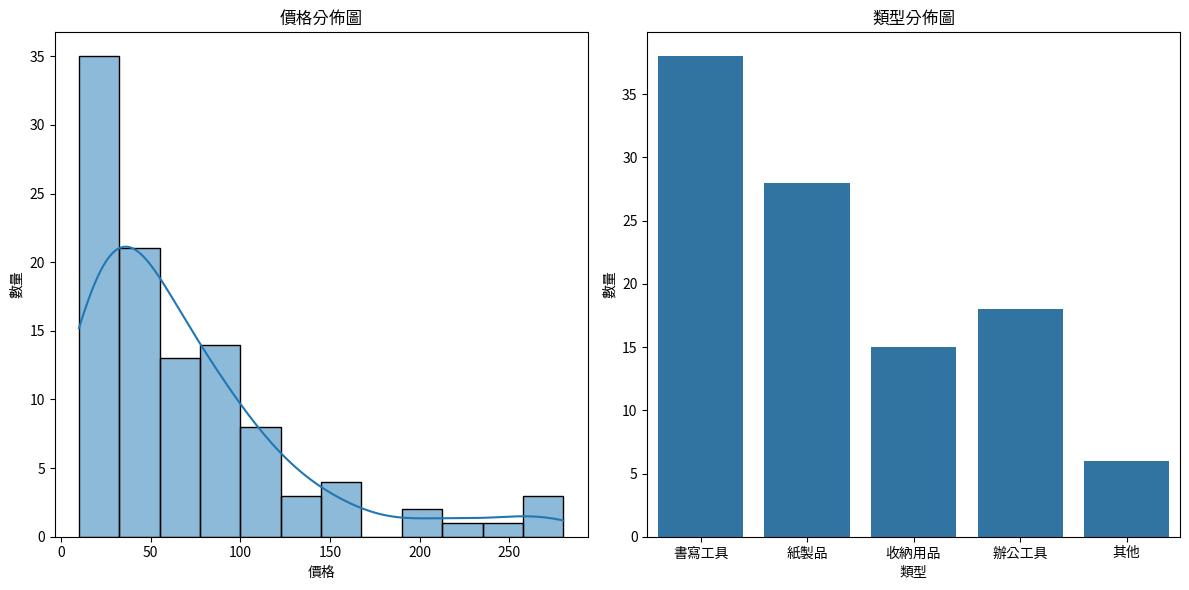

<Figure size 640x480 with 0 Axes>

In [19]:
# 資料集圖表分析
plt.figure(figsize=(12, 6))

# 價格分佈
plt.subplot(1, 2, 1)
sns.histplot(data['價格'], kde=True)
plt.title('價格分佈圖')
plt.xlabel('價格')
plt.ylabel('數量')

# 類型分佈
plt.subplot(1, 2, 2)
sns.countplot(x='類型', data=data)
plt.title('類型分佈圖')
plt.xlabel('類型')
plt.ylabel('數量')

plt.tight_layout()
plt.show()
plt.savefig('data_analysis.png')

In [3]:
# 資料預處理-(方法1)
le = LabelEncoder()
data['尺寸'] = le.fit_transform(data['尺寸'])
data['顏色'] = le.fit_transform(data['顏色'])
data['是否為書寫工具'] = le.fit_transform(data['是否為書寫工具'])
data['材質'] = le.fit_transform(data['材質'])
data['品牌'] = le.fit_transform(data['品牌'])

data

,物品名稱,類型,價格,尺寸,顏色,是否為書寫工具,材質,品牌
0,鋼筆,書寫工具,250,2,13,1,7,7
1,鉛筆,書寫工具,10,2,3,1,2,5
2,原子筆,書寫工具,15,2,8,1,0,9
3,螢光筆,書寫工具,30,2,12,1,0,6
4,毛筆,書寫工具,80,0,13,1,5,4
...,...,...,...,...,...,...,...,...
100,便條紙,紙製品,29,2,6,0,6,0
101,信紙,紙製品,43,0,4,0,6,8
102,日記本,紙製品,128,1,7,0,6,10
103,記事本,紙製品,83,2,7,0,6,8


In [ ]:
#選擇特徵和目標變量
X = data[['價格', '尺寸', '顏色', '是否為書寫工具', '材質', '品牌']]
y = data['類型']

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test

In [6]:
# 定義決策樹參數網格
# 這裡建立了一個叫做 param_grid 的字典 (dictionary)
# 裡面放了我們想要測試的決策樹模型的不同參數設定
param_grid = {
    # 'max_depth': 樹的最大深度，我們想試試看深度為 3, 5, 7, 10 的效果
    'max_depth': [3, 5, 7, 10],
    # 'min_samples_split': 節點要分裂前，至少需要多少樣本數，試試看 2, 5, 10
    'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': 一個葉節點 (最終節點) 最少需要多少樣本數，試試看 1, 2, 4
    'min_samples_leaf': [1, 2, 4]
}

# 使用網格搜尋 (Grid Search) 來優化參數
# GridSearchCV 是 scikit-learn 提供的一個工具，可以自動測試 param_grid 裡的所有參數組合
# DecisionTreeClassifier(random_state=42) 是我們要優化的基礎模型 (決策樹分類器)，random_state=42 是為了讓每次執行的結果都一樣
# param_grid 是上面定義的參數組合
# cv=5 表示使用 5 折交叉驗證 (cross-validation)，把訓練資料分成 5 份，輪流當驗證集，讓評估更可靠
# scoring='accuracy' 表示我們用「準確率」來評斷哪個參數組合最好
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

# 開始進行網格搜尋與模型訓練
# .fit() 會把訓練資料 (X_train, y_train) 拿進來
# GridSearchCV 會自動嘗試 param_grid 中的所有組合 (4 * 3 * 3 = 36 種組合)
# 對每種組合，用 5 折交叉驗證來計算平均準確率
clf.fit(X_train, y_train)

# 顯示找到的最佳參數與對應的模型
# .best_params_ 會告訴我們哪一組參數組合在交叉驗證中表現最好 (準確率最高)
print("最佳參數:", clf.best_params_)
# .best_estimator_ 會給我們用這組最佳參數，並且在「全部」訓練資料上重新訓練好的最終決策樹模型
best_clf = clf.best_estimator_

最佳參數: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


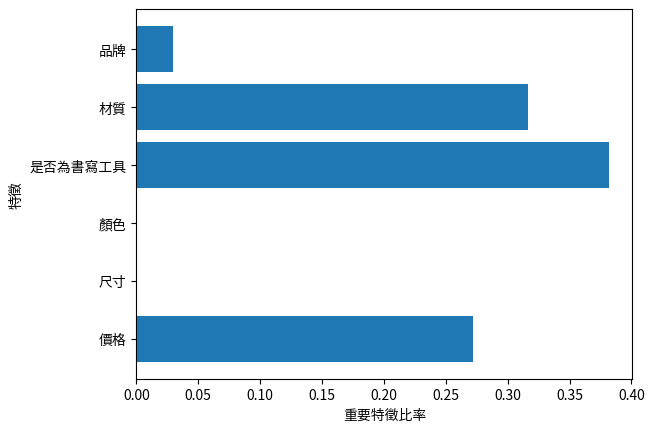

In [16]:
#重要特微的屬性
n_features = len(X.columns)
plt.barh(range(n_features), best_clf.feature_importances_, align='center')
plt.yticks(np.arange(n_features),X.columns)
plt.xlabel("重要特徵比率")
plt.ylabel("特徵")
plt.show()

In [17]:
y_pred = best_clf.predict(X_test)

# 評估模型
accuracy = accuracy_score(y_test, y_pred)
print(f"模型準確率: {accuracy:.2f}")
print("\n分類報告:")
print(classification_report(y_test, y_pred))

模型準確率: 1.00

分類報告:
              precision    recall  f1-score   support

          其他       1.00      1.00      1.00         1
        收納用品       1.00      1.00      1.00         6
        書寫工具       1.00      1.00      1.00        11
         紙製品       1.00      1.00      1.00        10
        辦公工具       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



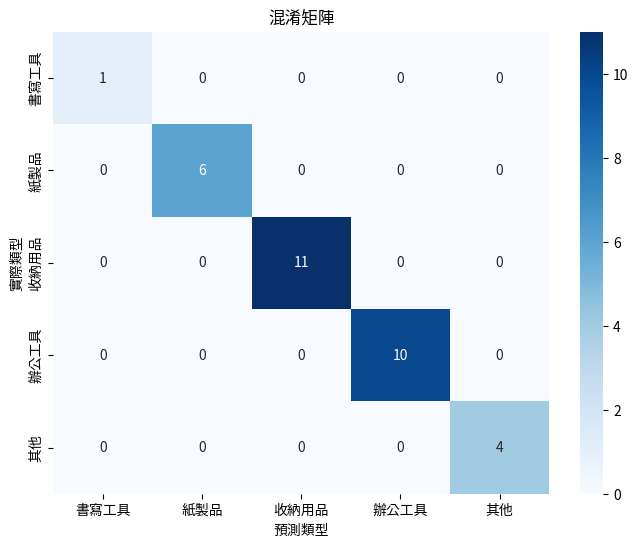

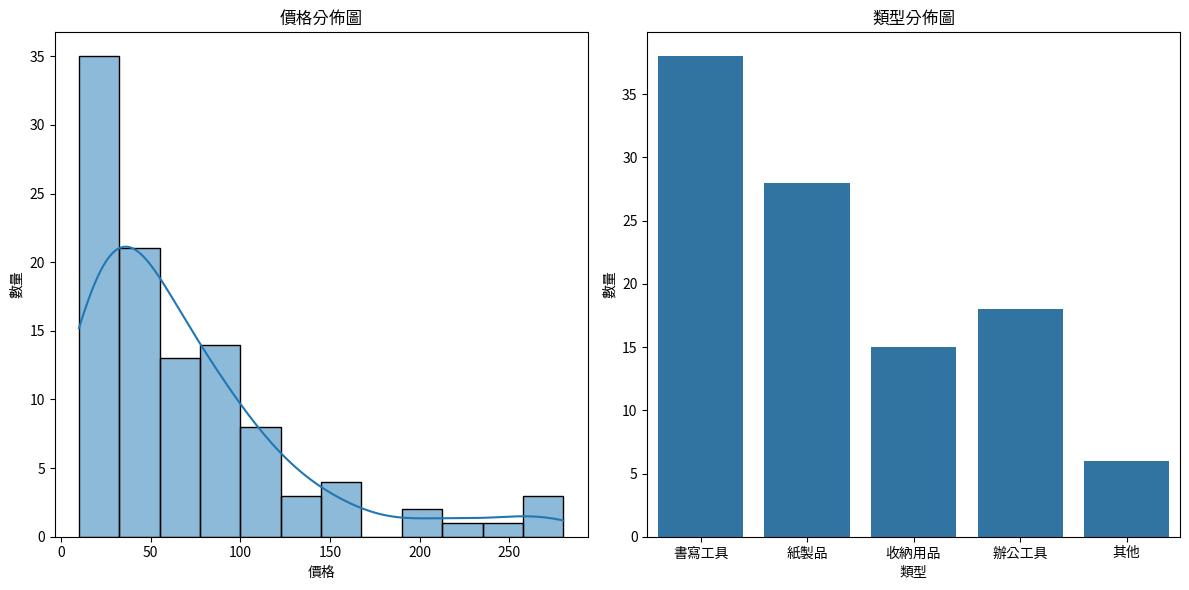

<Figure size 640x480 with 0 Axes>

In [ ]:
# 混淆矩陣圖表
cm = confusion_matrix(y_test, y_pred)
class_names = data['類型'].unique()  # 獲取產品類型的唯一值
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('混淆矩陣')
plt.xlabel('預測類型')
plt.ylabel('實際類型')
plt.savefig('confusion_matrix.png')



### 方法1
sklearn.preprocessing 裡的 `LabelEncoder`，它的主要功能是將類別型的`特徵（通常是文字標籤）轉換成數值型的標籤`。

**詳細說明**：

le = LabelEncoder(): 這一行是建立（初始化）一個 LabelEncoder 物件，我們將用這個物件 le 來進行轉換。  
data['尺寸'] = le.fit_transform(data['尺寸']): 這一行做了兩件事： 
fit(): LabelEncoder 首先會學習（fit）data['尺寸'] 這一欄中所有不重複的類別值（例如：'小型', '中型', '大型'）。  
transform(): 接著，它會將這些類別值轉換成對應的整數。例如，它可能會把 '小型' 轉成 0，'中型' 轉成 1，'大型' 轉成 2（具體的數字分配取決於類別出現的順序）。fit_transform() 方法結合了這兩個步驟，直接學習並轉換該欄位。  
後續幾行: 對於 '顏色', '是否為書寫工具', '材質', '品牌' 這幾欄，程式碼重複了同樣的步驟，將這些欄位中的文字類別轉換成數值標籤。  

**為什麼要這樣做？**

許多機器學習演算法（包括這個筆記本後面使用的決策樹 DecisionTreeClassifier）無法直接處理文字型的類別資料，它們需要輸入是數值型態。LabelEncoder 就是一種將這些文字特徵轉換成演算法可以理解的數值格式的常用方法。

簡單來說，LabelEncoder 把像 '黑色'、'藍色'、'紅色' 這樣的文字，轉換成 0, 1, 2 這樣的數字，讓機器學習模型能夠處理這些特徵。